In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#%matplotlib notebook
%matplotlib inline

In [3]:
import os
cwd = os.getcwd()

NOTEBOOK_DIR = os.path.dirname(cwd)
ROOT = os.path.dirname(os.path.dirname(os.path.dirname(NOTEBOOK_DIR)))

FIGURES_DIR = os.path.join(ROOT, 'figures/abc_parameterizations/1d')
CONFIG_PATH = os.path.join(ROOT, 'pytorch/configs/abc_parameterizations/fc_abc.yaml')

In [4]:
import sys
sys.path.append(ROOT)

In [5]:
import torch
import pickle
from utils.tools import load_pickle

from utils.tools import read_yaml, set_random_seeds
from utils.plot.abc_parameterizations.initializations import *
from utils.plot.abc_parameterizations.one_d_functions import *
from pytorch.configs.base import BaseConfig
from pytorch.configs.model import ModelConfig
from pytorch.models.abc_params.fully_connected import ip, muP, ipllr
from pytorch.models.abc_params.fully_connected.standard_fc_ip import StandardFCIP

## Set variables

In [6]:
SEED = 42
N_SAMPLES = 100
N_TRAIN = 10
BASE_LR = 0.1

set_random_seeds(SEED)  # set random seed for reproducibility
config_dict = read_yaml(CONFIG_PATH)
base_config = ModelConfig(config_dict)

# modify config for this notebook
base_config.architecture['input_size'] = 1
base_config.architecture['output_size'] = 1
base_config.architecture['bias'] = False
base_config.activation.name = 'relu'
base_config.loss.name = 'mse'
base_config.optimizer.params['lr'] = BASE_LR

In [7]:
xs, ys = generate_1d_data(n_samples=10)

In [8]:
batch_xs = torch.unsqueeze(xs, 1)
batch_ys = torch.unsqueeze(ys, 1)

In [9]:
batches = [(batch_xs, batch_ys) for _ in range(3)]

## Define models

In [10]:
WIDTHS = [1024]
N_WARMUP_STEPS = 1  # 4
L = 4
N_TRIALS = 5  # 5
N_EPOCHS = 3000 # 6000

In [11]:
name_to_model_dict = {
    'muP': muP.FCmuP,
    'IPLLR': ipllr.FcIPLLR
}

In [12]:
models_dict = dict()
for name, model in name_to_model_dict.items():
    models_dict[name] = dict()
    for width in WIDTHS:  # define models with different widths
        # first modify the base common config
        config = deepcopy(base_config)
        config.name = name
        config.architecture['width'] = width
        config.architecture['n_layers'] = L + 1
        
        if name == 'IPLLR':
            scheduler_config = {'name': 'warmup_switch', 
                                'params': {'n_warmup_steps': N_WARMUP_STEPS,
                                           'calibrate_base_lr': True,
                                           'default_calibration': False}}
            config.scheduler = BaseConfig(scheduler_config)
            config.optimizer.params['lr'] = 0.1
            
            models_dict[name][width] = [name_to_model_dict[name](config, lr_calibration_batches=batches) 
                                        for _ in range(N_TRIALS)]
            
        elif name == 'muP':
            config.optimizer.params['lr'] = BASE_LR
            models_dict[name][width] = [name_to_model_dict[name](config) for _ in range(N_TRIALS)]

initial base lr : [5.333288192749023, 3.5005691051483154, 6.639917850494385, 6.488011360168457, 2.54469633102417]
initial base lr : [5.131367206573486, 4.075309753417969, 8.057148933410645, 7.403464317321777, 2.9157402515411377]
initial base lr : [5.380590438842773, 3.7062199115753174, 7.488490581512451, 7.366723537445068, 2.899665117263794]
initial base lr : [5.619283199310303, 4.297327518463135, 8.466697692871094, 7.944214820861816, 2.9649553298950195]
initial base lr : [5.075410842895508, 3.7607944011688232, 7.8891777992248535, 7.329678535461426, 2.7181649208068848]


### Set U and v to be the same for all models

In [13]:
for name in models_dict.keys():
    if name != 'muP':
        for width in WIDTHS:
            for i in range(N_TRIALS):
                ntk = models_dict['muP'][width][i]
                model = models_dict[name][width][i]
                with torch.no_grad():
                    model.copy_initial_params_from_model(ntk, check_model=True)
                    model.initialize_params()

In [14]:
init_dict = dict()
for name in models_dict.keys():
    init_dict[name] = dict()
    for width in WIDTHS:
        init_dict[name][width] = [deepcopy(model) for model in models_dict[name][width]]

In [15]:
models_dict_copy = deepcopy(models_dict)

In [16]:
#batch_xs = torch.unsqueeze(xs, 1)
#batch_ys = torch.unsqueeze(ys, 1)
for name in models_dict.keys():
    for width in WIDTHS:
        for model in models_dict[name][width]:
            fit_model(model, batch_xs, batch_ys, n_epochs=N_EPOCHS)

#for name in ['IPLLR']:
#for name in ['muP']:
#    for width in WIDTHS:
#        for model in models_dict[name][width]:
#            fit_model(model, batch_xs, batch_ys, n_epochs=N_EPOCHS)

### muP

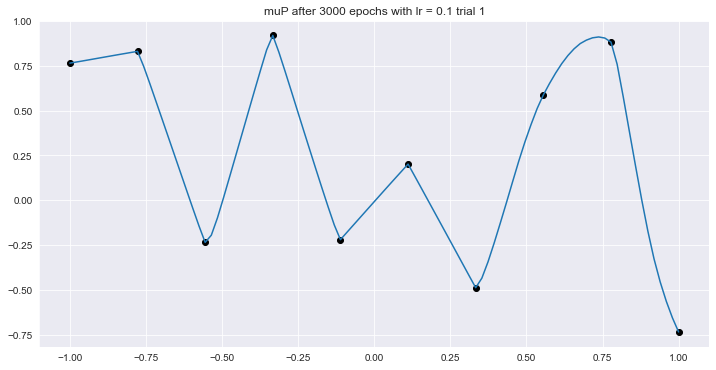

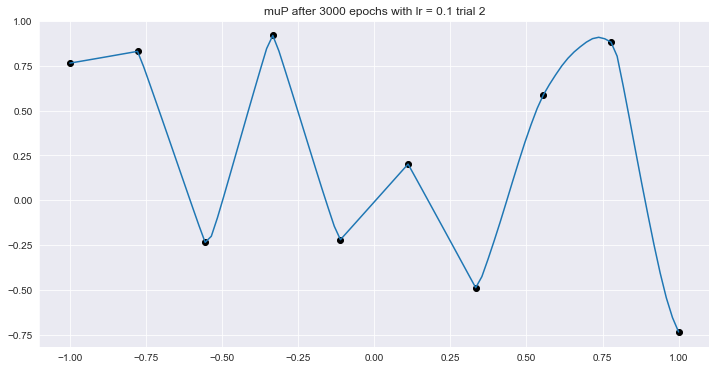

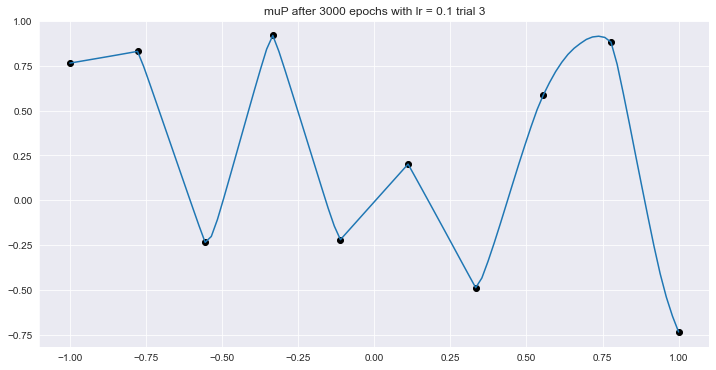

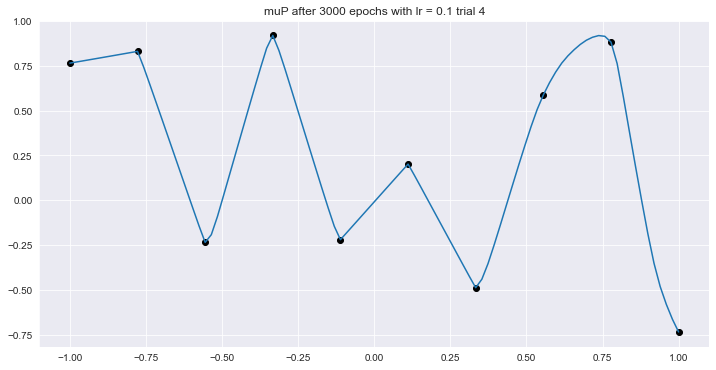

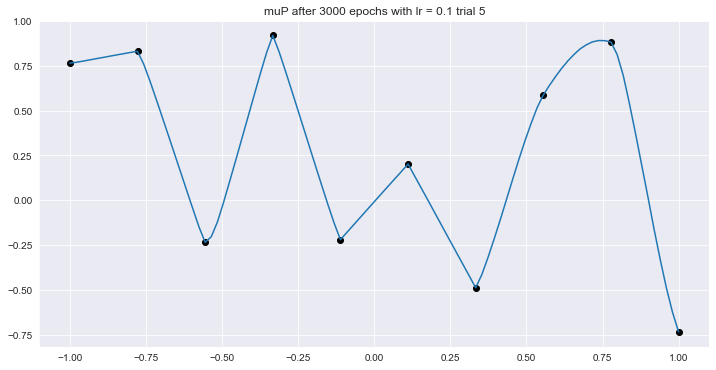

In [17]:
name = 'muP'
for k in range(len(models_dict[name][1024])):
    model = models_dict[name][1024][k]
    plt.figure(figsize=(12, 6))
    plot_model(model, xs, ys, label=name, scatter=True)
    plt.title('muP after {} epochs with lr = {} trial {:,}'.format(N_EPOCHS, model.base_lr, k + 1))
    plt.savefig(os.path.join(FIGURES_DIR, '{}_lr={}_{}_trial_{}.png'.format(name, model.base_lr, N_EPOCHS, k+1)))
    # plt.ylim(-0.0001, 0.0001)
    plt.show()

/Users/karlhajjar/Documents/projects/wide-networks/env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


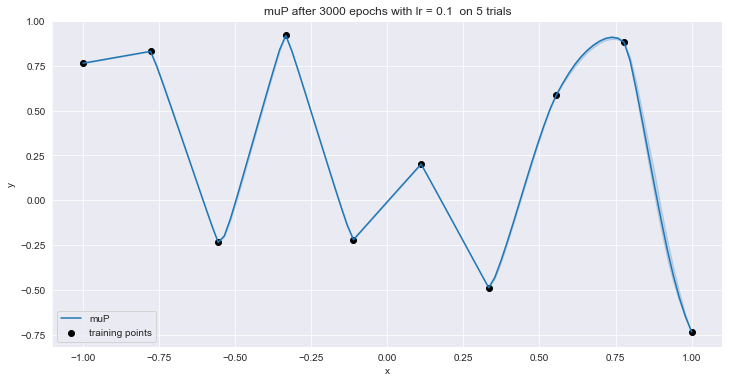

In [18]:
name = 'muP'
base_lr = models_dict[name][1024][0].base_lr
plt.figure(figsize=(12, 6))
plot_model(models_dict[name][1024], xs, ys, label=name, scatter=True)
# plt.ylim(-0.0001, 0.0001)
plt.title('muP after {} epochs with lr = {}  on {} trials'.format(N_EPOCHS, base_lr, N_TRIALS))
plt.savefig(os.path.join(FIGURES_DIR, '{}_lr={}_{}_trials_{}.png'.format(name, base_lr, N_EPOCHS, N_TRIALS)))
plt.show()

### IP-LLLR

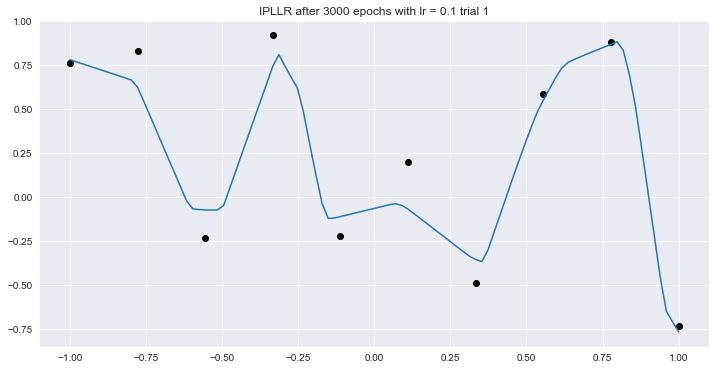

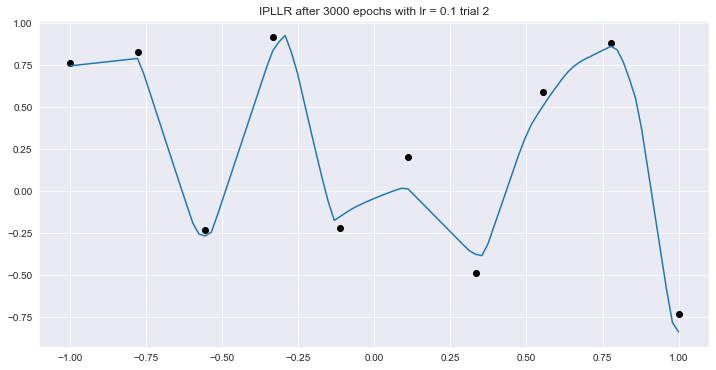

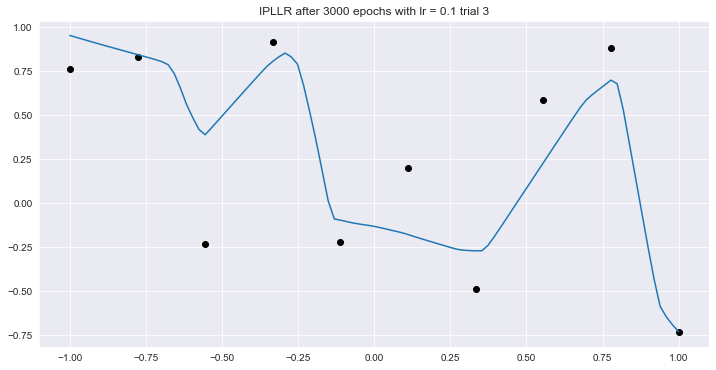

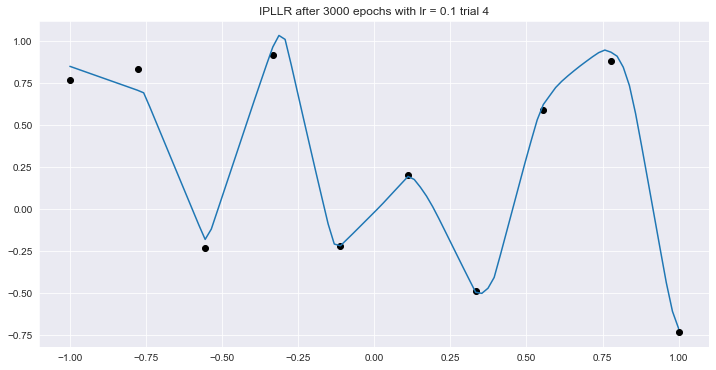

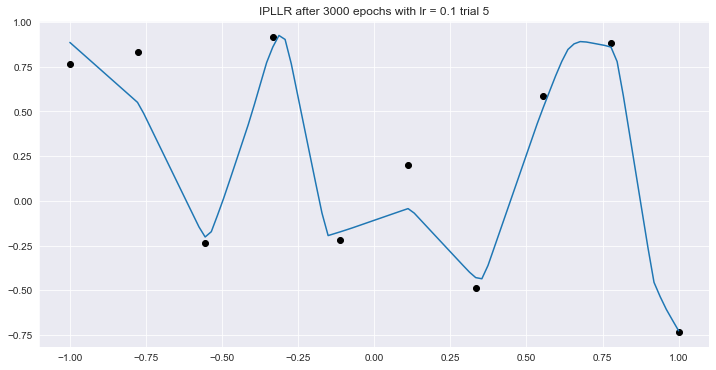

In [21]:
name = 'IPLLR'
for k in range(len(models_dict[name][1024])):
    model = models_dict[name][1024][k]
    plt.figure(figsize=(12, 6))
    plot_model(model, xs, ys, label=name, scatter=True)
    plt.title('IPLLR after {} epochs with lr = {} trial {:,}'.format(N_EPOCHS, model.base_lr, k + 1))
    #plt.savefig(os.path.join(FIGURES_DIR, '{}_lr={}_{}_trial_{}.png'.format(name, model.base_lr, N_EPOCHS, k+1)))

    # plt.ylim(-0.0001, 0.0001)
    plt.show()

/Users/karlhajjar/Documents/projects/wide-networks/env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


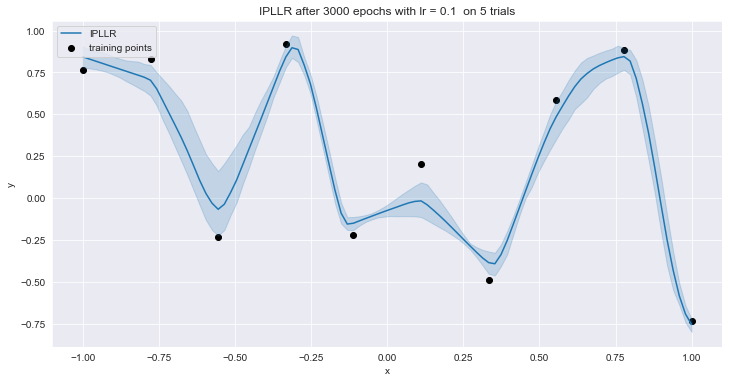

In [22]:
name = 'IPLLR'
base_lr = models_dict[name][1024][0].base_lr

plt.figure(figsize=(12, 6))
plot_model(models_dict[name][1024], xs, ys, label=name, scatter=True)
# plt.ylim(-0.0001, 0.0001)
plt.title('IPLLR after {} epochs with lr = {}  on {} trials'.format(N_EPOCHS, base_lr, N_TRIALS))
#plt.savefig(os.path.join(FIGURES_DIR, '{}_lr={}_{}_trials_{}.png'.format(name, base_lr, N_EPOCHS, N_TRIALS)))

plt.show()